# Visualise interaction between 2 variables with parallel sets diagrams

I-Hsuan Lin

University of Manchester

November 03, 2021

## 1. Introduction

This notebook shows readers how to use `ggforce` package to create parallel sets diagram to show the interaction between 2 categorical variables.

### About demo datasets

All the datasets are available from CRAN or bioconductor.

1. The `Titanic` dataset (from R) provides information on the fate of passengers on the ocean liner ‘Titanic’.
2. The [fission](https://www.bioconductor.org/packages/release/data/experiment/html/fission.html) dataset provides a `RangedSummarizedExperiment` object of read counts in genes for a time course RNA-Seq experiment of fission yeast (*Schizosaccharomyces pombe*) in response to oxidative stress at 0, 15, 30, 60, 120 and 180 mins.
3. The [TENxPBMCData](https://bioconductor.org/packages/release/data/experiment/html/TENxPBMCData.html) single-cell RNA-seq data for on PBMC cells, generated by 10X Genomics.

## 2. Loading required libraries

In [1]:
library(ggforce)
library(pals)
library(tidyverse)

# To Run fission demo
library(DESeq2)
library(fission)

# To Run PBMC demo
library(scater)
library(scran)
library(bluster)
library(TENxPBMCData)

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘tidyr’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: paralle

## 3. Set output parameters

In [2]:
# Set width
options(width = 110)

# Set output image size
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 150)

## 4. Load functions

The `plot_parallel` function allows users to create plots easily by providing the membership information. The required arguments to use the function are `lab1` and `lab2` which are the membership information to be displayed. 

Optional settings are:
- `labels`: vector of labels for the 2 categorical variables. Default values are `label1` and `label2`.
- `add_counts`: boolean value showing if total counts of each element is displayed with the labels. Default value is `FALSE` (i.e. not showing counts).
- `text_size`: variable label size. Default value is 4.
- `xlab_size`: main categorical label size. Default value is 14.
- `base_size`: base font size, given in pts. Default value is 20.
- `color`: color palette of the elements in the parallel sets diagram. Default is to use `ggplot2`'s default color palette.

In [3]:
plot_parallel <- function(lab1, lab2, labels = c("label1", "label2"), add_counts = FALSE, text_size = 4, 
                          xlab_size = 14, base_size = 20, color = NULL) {
    if(length(lab1) == 0 | length(lab2) == 0) {
        return("Empty input.")
    }

    # Encode vectors as factors, or drop unused levels
    if(!is.factor(lab1)) {
        lab1 <- as.factor(lab1)
    } else {
        lab1 <- droplevels(lab1)
    }

    if(!is.factor(lab2)) {
        lab2 <- as.factor(lab2)
    } else {
        lab2 <- droplevels(lab2)
    }
    
    # Calculate and append counts to labels
    if(add_counts == TRUE) {
        lab1name <- data.frame(lab = lab1) %>% dplyr::count(lab) %>% 
            mutate(name = paste0(lab, " (", n, ")")) %>% pull(name)
        levels(lab1) <- lab1name
        
        lab2name <- data.frame(lab = lab2) %>% dplyr::count(lab) %>% 
            mutate(name = paste0(lab, " (", n, ")")) %>% pull(name)
        levels(lab2) <- lab2name
    }

    # Rename labels if duplicate names used in the 2 sets
    if(length(intersect(levels(lab1), levels(lab2))) > 0) {
        levels(lab1) <- paste0("(", labels[1], ") ", levels(lab1))
        levels(lab2) <- paste0("(", labels[2], ") ", levels(lab2))
    }
    
    # Build data.frame
    data <- data.frame(lab1 = lab1, lab2 = lab2) %>%
    group_by(lab1, lab2) %>% tally() %>% ungroup() %>% drop_na() %>% gather_set_data(1:2) %>% 
    mutate(x = factor(x, levels = c("lab1", "lab2"))) %>% mutate(y = fct_drop(y))

    data_labels <- tibble(group = unique(data[,c("x", "y")])$x) %>%
    mutate(hjust = ifelse(group == "lab2", 0, 1),
           nudge_x = ifelse(group == "lab2", 0.1, -0.1))
    
    # Build ggplot object
    p <- ggplot(data, aes(x, id = id, split = y, value = n)) +
    geom_parallel_sets(aes(fill = lab1), alpha = 0.6, axis.width = 0.15) +
    geom_parallel_sets_axes(aes(fill = y), color = "black", size = 0.3, axis.width = 0.1) +
    geom_text(aes(y = n, split = y), stat = "parallel_sets_axes",
              hjust = data_labels$hjust, nudge_x = data_labels$nudge_x,
              fontface = "bold", color = "black", size = text_size) +
    scale_x_discrete(labels = labels) + theme_void(base_size = base_size) +
    theme(legend.position = "none", plot.margin = unit(c(1, 1, 1, 1), "lines"),
          axis.text.x = element_text(face = "bold", color = "black", size = xlab_size))

    if(!is.null(color)) {
        p <- p + scale_fill_manual(values = color)
    }
    
    return(p)
}

## 5. Create plots

### Use `Titanic` dataset

In [4]:
dat <- reshape2::melt(Titanic)
str(dat)

'data.frame':	32 obs. of  5 variables:
 $ Class   : Factor w/ 4 levels "1st","2nd","3rd",..: 1 2 3 4 1 2 3 4 1 2 ...
 $ Sex     : Factor w/ 2 levels "Male","Female": 1 1 1 1 2 2 2 2 1 1 ...
 $ Age     : Factor w/ 2 levels "Child","Adult": 1 1 1 1 1 1 1 1 2 2 ...
 $ Survived: Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ value   : num  0 0 35 0 0 0 17 0 118 154 ...


In [5]:
table(dat$Class, dat$Age)

      
       Child Adult
  1st      4     4
  2nd      4     4
  3rd      4     4
  Crew     4     4

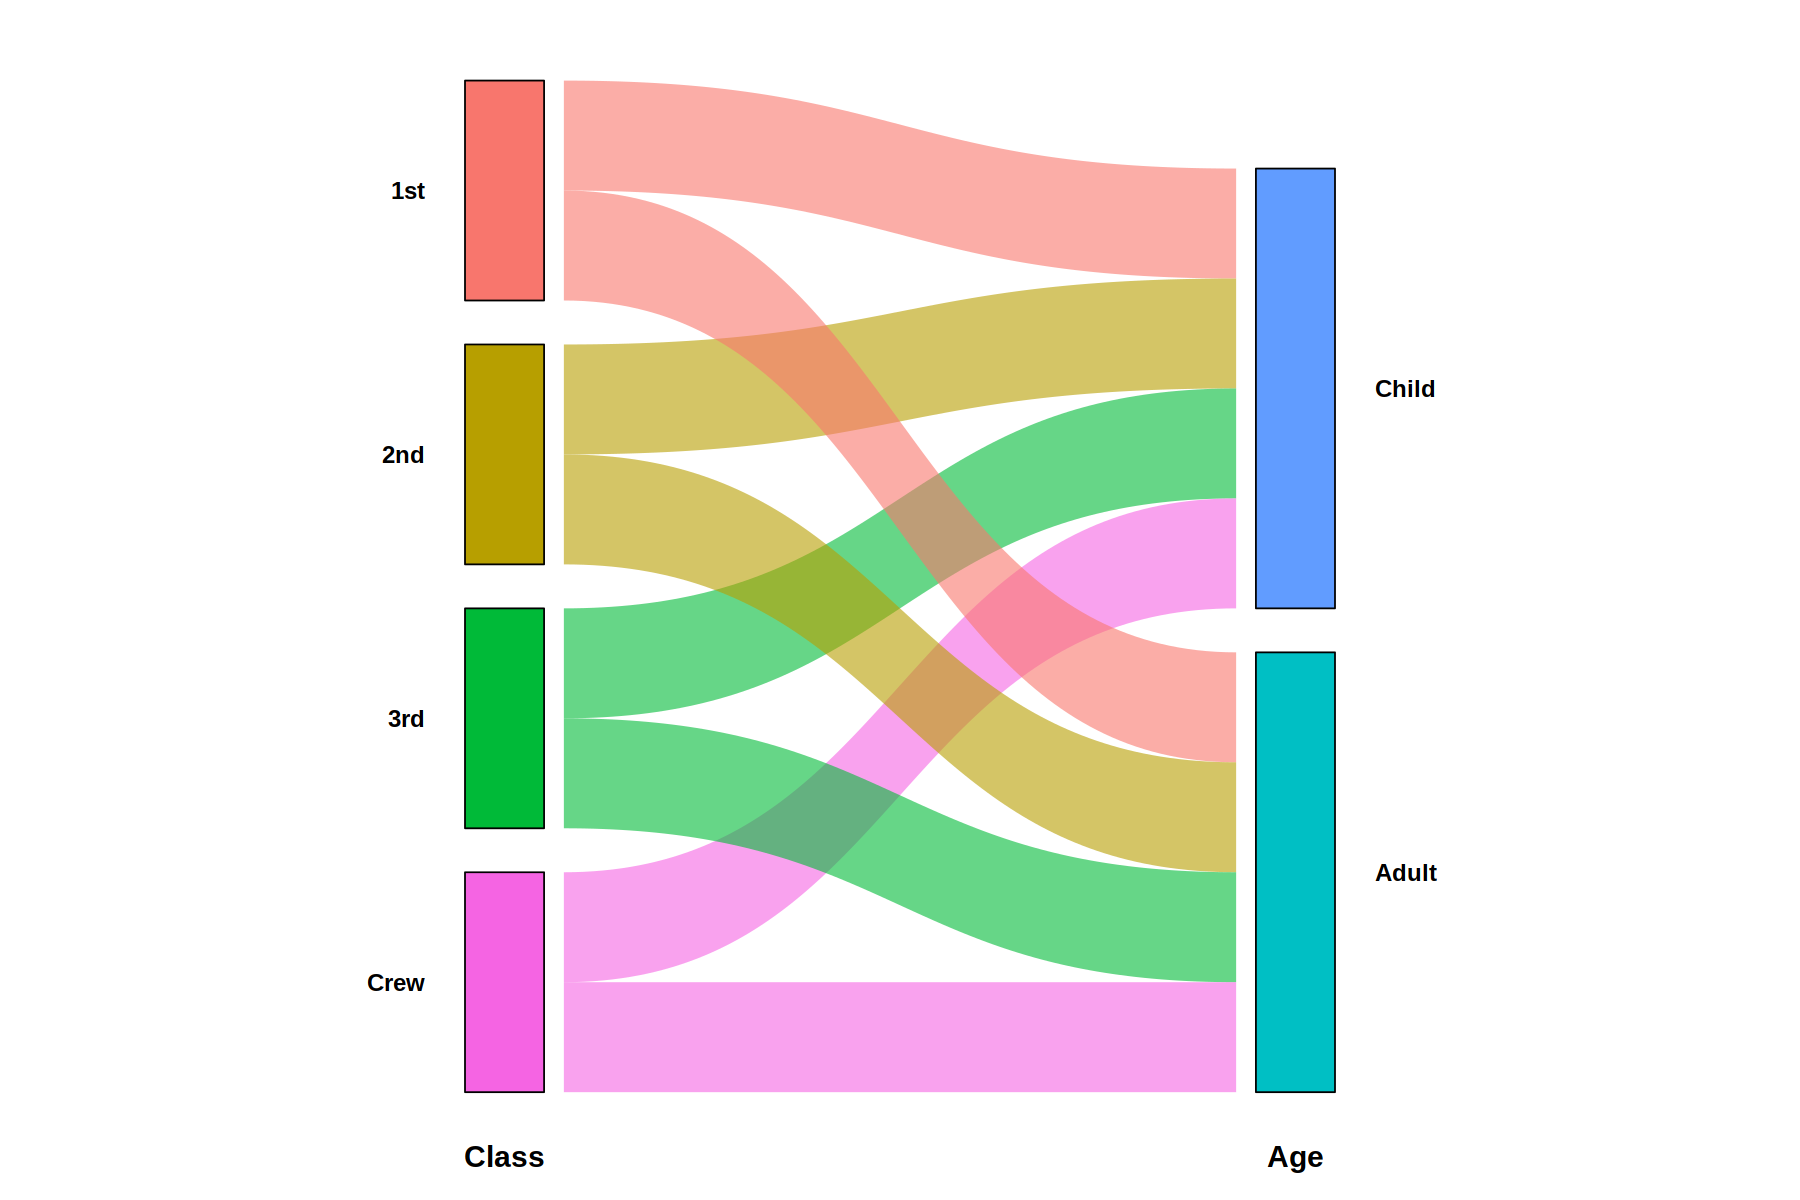

In [6]:
# Show class and age relationships of the passengers
plot_parallel(dat$Class, dat$Age, labels = c("Class", "Age"))

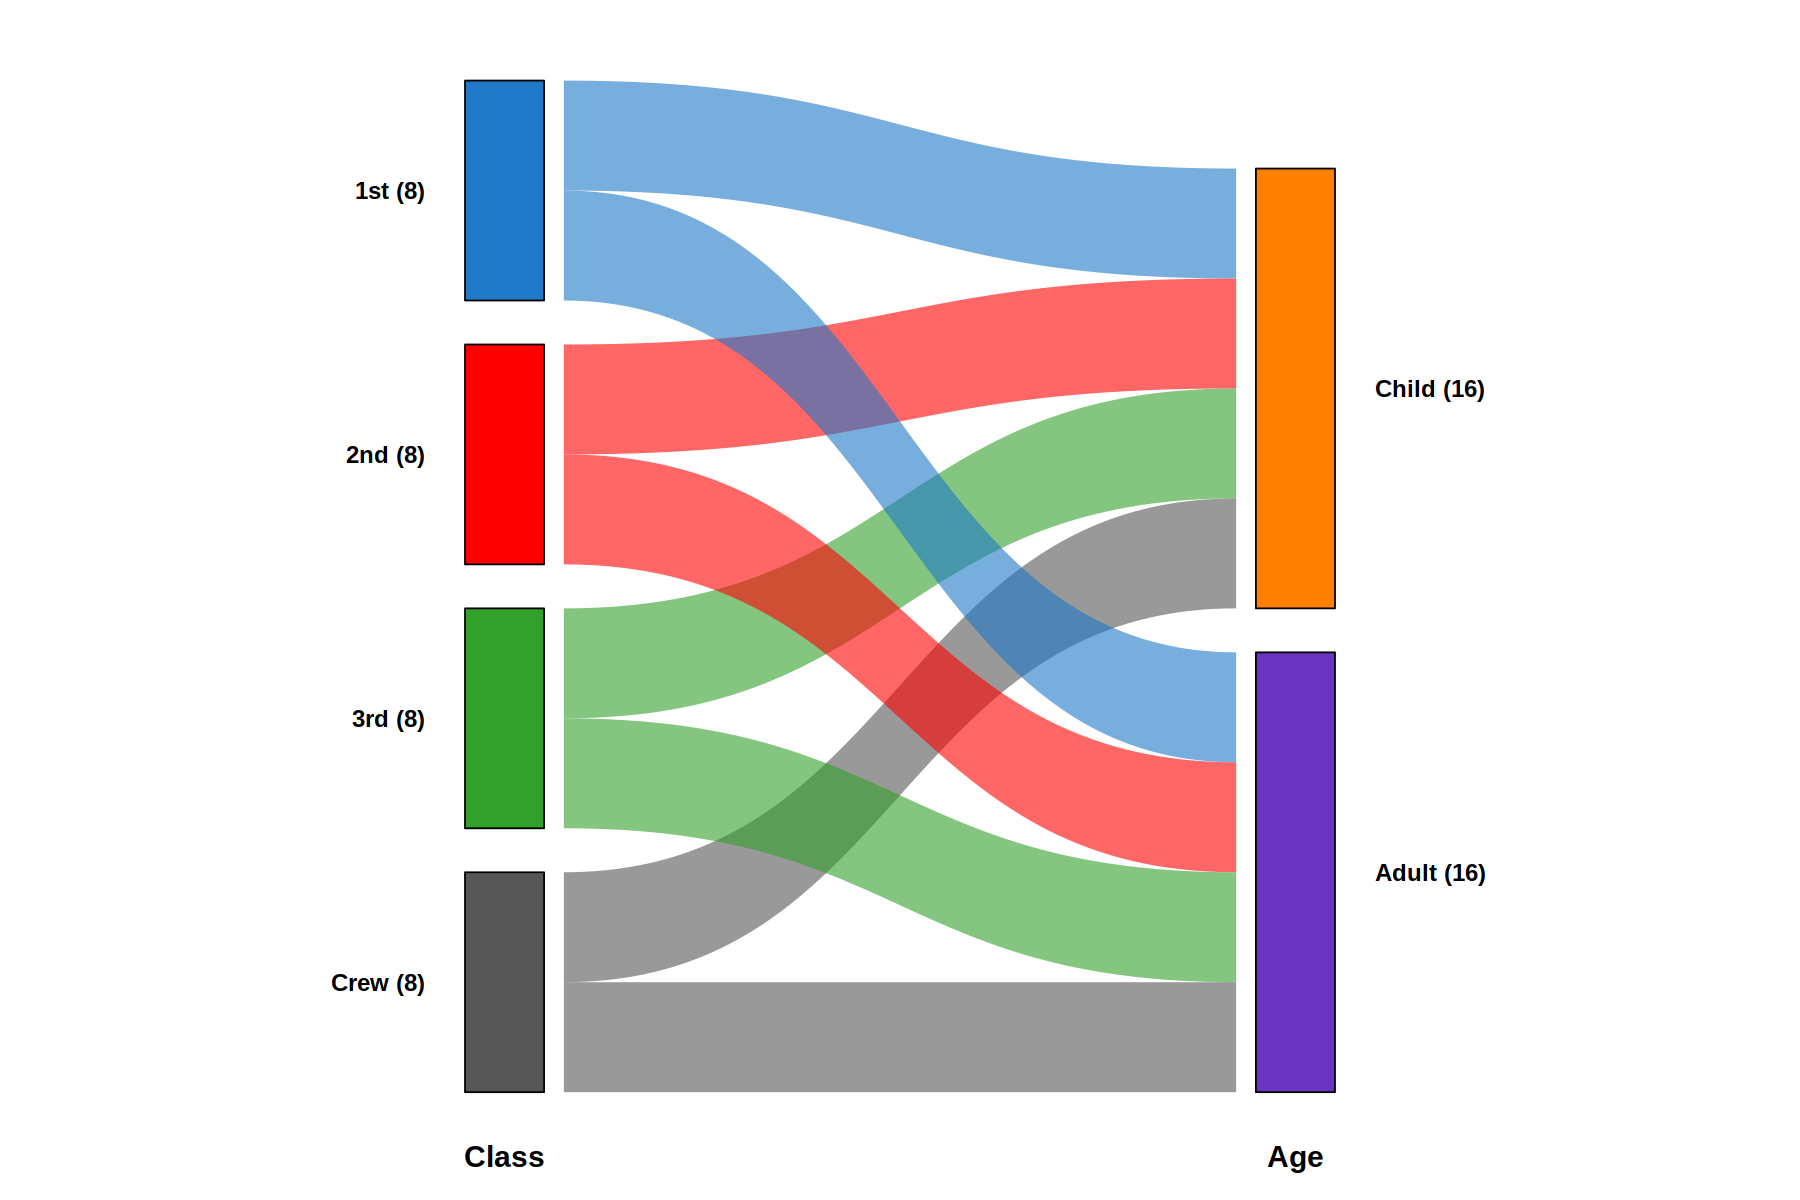

In [7]:
# Show class and age relationships of the passengers,
# change colour and add number of passengers in each classification
plot_parallel(dat$Class, dat$Age, labels = c("Class", "Age"), color = cols25(), add_counts = TRUE)

### Use `fission` dataset

In [8]:
#--- data-loading ---#
data("fission")
fission
str(data.frame(colData(fission)))

class: RangedSummarizedExperiment 
dim: 7039 36 
metadata(1): ''
assays(1): counts
rownames(7039): SPAC212.11 SPAC212.09c ... SPMITTRNAGLU.01 SPMIT.11
rowData names(2): symbol biotype
colnames(36): GSM1368273 GSM1368274 ... GSM1368307 GSM1368308
colData names(4): strain minute replicate id

'data.frame':	36 obs. of  4 variables:
 $ strain   : Factor w/ 2 levels "wt","mut": 1 1 1 1 1 1 1 1 1 1 ...
 $ minute   : Factor w/ 6 levels "0","15","30",..: 1 1 1 2 2 2 3 3 3 4 ...
 $ replicate: Factor w/ 3 levels "r1","r2","r3": 1 2 3 1 2 3 1 2 3 1 ...
 $ id       : chr  "wt_0_r1" "wt_0_r2" "wt_0_r3" "wt_15_r1" ...


In [9]:
#--- subset to 2 time points ---#
sel <- colData(fission)$minute %in% c(60,180)
DF <- droplevels(colData(fission)[sel,])
counts <- assay(fission)[,sel]
counts <- counts[rowMeans(counts) > 5,]

In [10]:
#--- construct DESeqDataSet ---#
dds<- DESeqDataSetFromMatrix(counts, DF, ~ strain * minute)
dds

class: DESeqDataSet 
dim: 6109 12 
metadata(1): version
assays(1): counts
rownames(6109): SPAC212.11 SPAC212.09c ... SPMITTRNAGLU.01 SPMIT.11
rowData names(0):
colnames(12): GSM1368282 GSM1368283 ... GSM1368307 GSM1368308
colData names(4): strain minute replicate id

In [11]:
#--- run DESeq ---#
dds <- DESeq(dds)
data.frame(coef = resultsNames(dds))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



coef
<chr>
Intercept
strain_mut_vs_wt
minute_180_vs_60
strainmut.minute180


In [12]:
#--- test strain (genotype) effect ---#
res_strain <- results(dds, name = "strain_mut_vs_wt")
head(res_strain[order(res_strain$pvalue),])

log2 fold change (MLE): strain mut vs wt 
Wald test p-value: strain mut vs wt 
DataFrame with 6 rows and 6 columns
              baseMean log2FoldChange     lfcSE      stat      pvalue        padj
             <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
SPAC1002.18   677.1550        0.95546  0.126453   7.55582 4.16221e-14 2.54228e-10
SPAC1002.19   811.1557        1.51290  0.217970   6.94083 3.89793e-12 1.19043e-08
SPCC1235.14   215.7377        1.08266  0.164224   6.59259 4.32205e-11 8.79969e-08
SPBC2F12.09c   25.5365        2.60858  0.431522   6.04507 1.49342e-09 2.28046e-06
SPAC186.02c    16.6919       -4.12837  0.710916  -5.80710 6.35626e-09 7.76480e-06
SPAC1002.17c  585.3025        1.23363  0.215299   5.72987 1.00507e-08 1.02316e-05

In [13]:
#--- test time effect ---#
res_time <- results(dds, name = "minute_180_vs_60")
head(res_time[order(res_time$pvalue),])

log2 fold change (MLE): minute 180 vs 60 
Wald test p-value: minute 180 vs 60 
DataFrame with 6 rows and 6 columns
              baseMean log2FoldChange     lfcSE      stat      pvalue        padj
             <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
SPAC1002.19    811.156       -4.46306  0.256866  -17.3750 1.27591e-67 7.79327e-64
SPAC1002.17c   585.303       -4.19440  0.254526  -16.4792 5.17391e-61 1.58011e-57
SPBC1289.14    328.622       -4.09307  0.322894  -12.6762 8.00953e-37 1.63074e-33
SPAC1002.18    677.155       -1.69681  0.136455  -12.4349 1.68934e-35 2.57962e-32
SPAC4H3.03c    339.124       -3.06392  0.257470  -11.9001 1.18224e-32 1.44423e-29
SPBC660.06    1999.315       -1.99969  0.173224  -11.5440 7.91673e-31 8.05923e-28

In [14]:
#--- set alpha at 0.1 ---#
sig_strain <- res_strain$padj < 0.1
sig_strain <- as.factor(as.character(sig_strain))
levels(sig_strain) <- c("Not Significant", "Significant")
table(sig_strain)

sig_time <- res_time$padj < 0.1
sig_time <- as.factor(as.character(sig_time))
levels(sig_time) <- c("Not Significant", "Significant")
table(sig_time)

sig_strain
Not Significant     Significant 
           6085              23 

sig_time
Not Significant     Significant 
           4863            1245 

In [15]:
table(sig_strain, sig_time)

                 sig_time
sig_strain        Not Significant Significant
  Not Significant            4858        1227
  Significant                   5          18

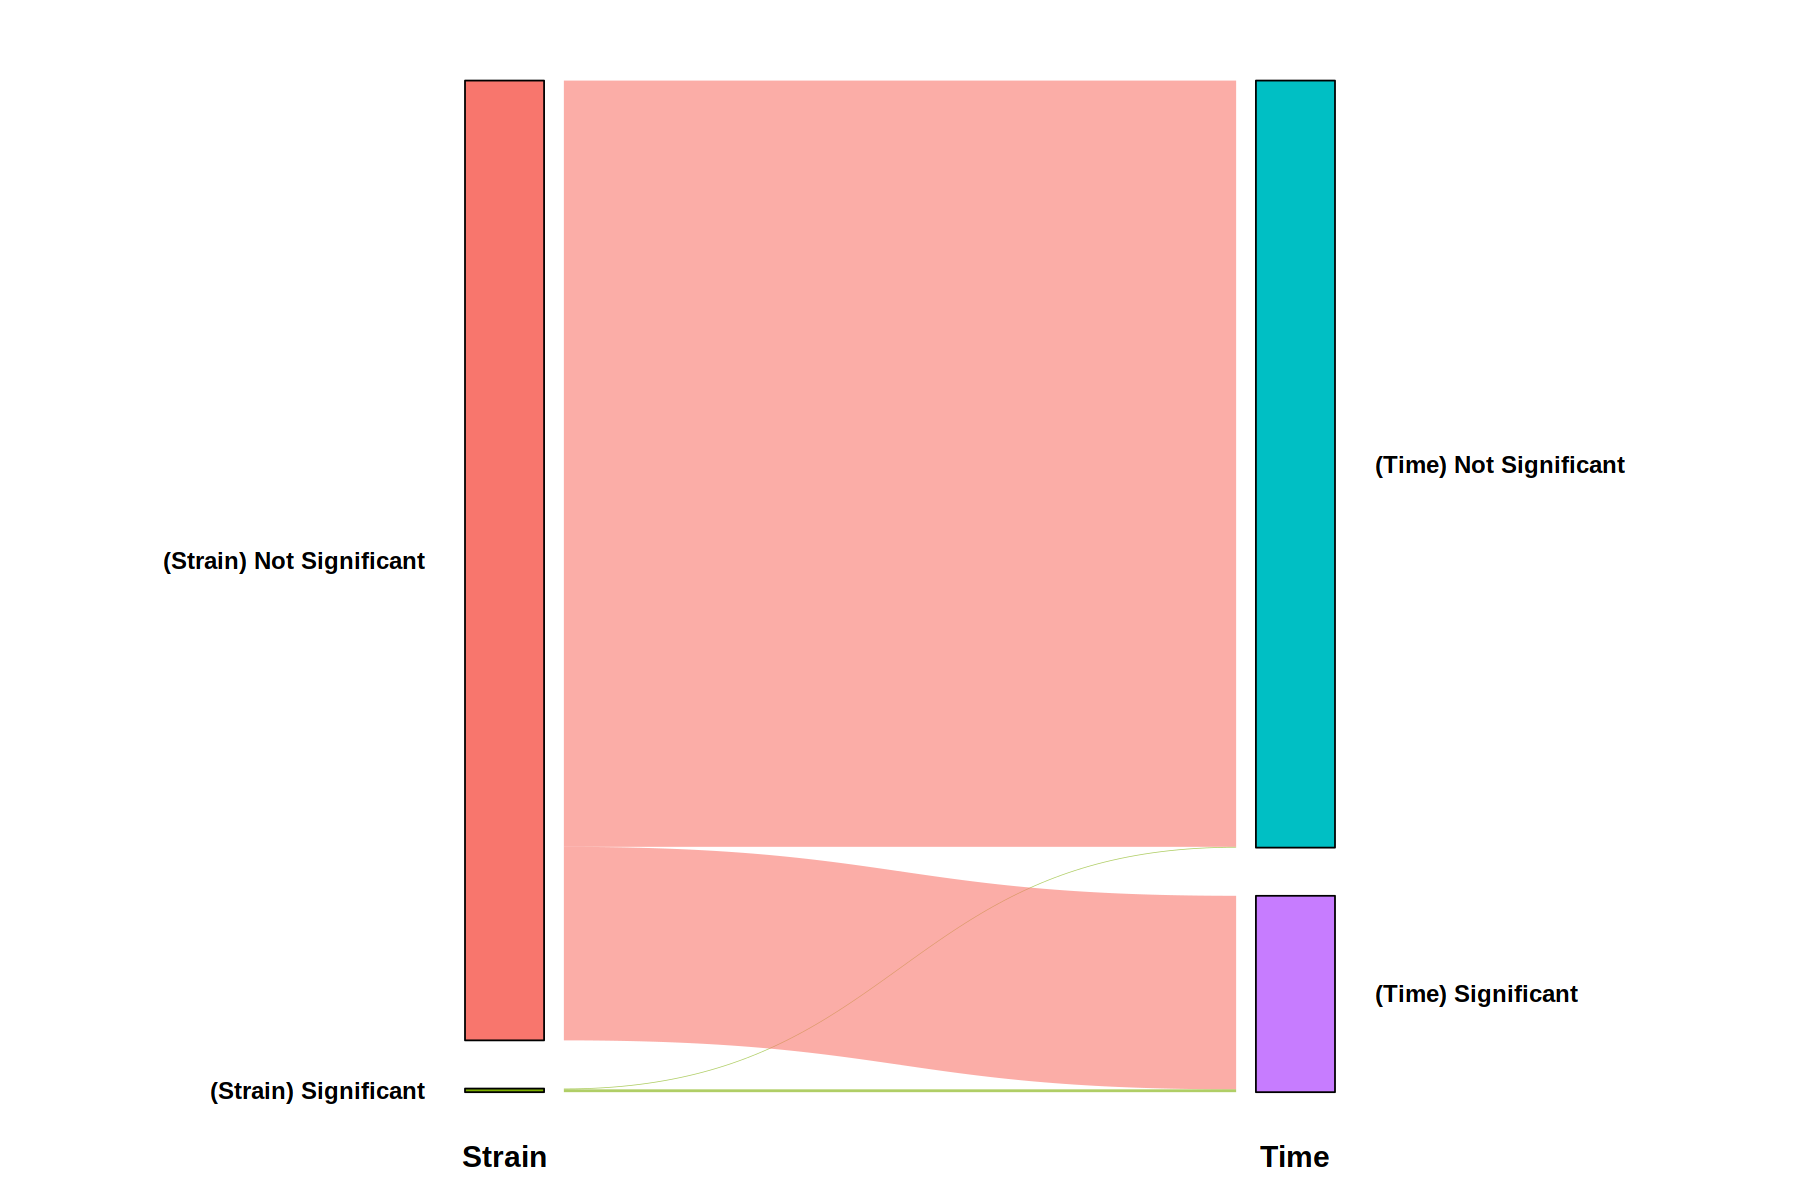

In [16]:
# Show relationships of the genes that have a significant strain and time effects
plot_parallel(sig_strain, sig_time, labels = c("Strain", "Time"))

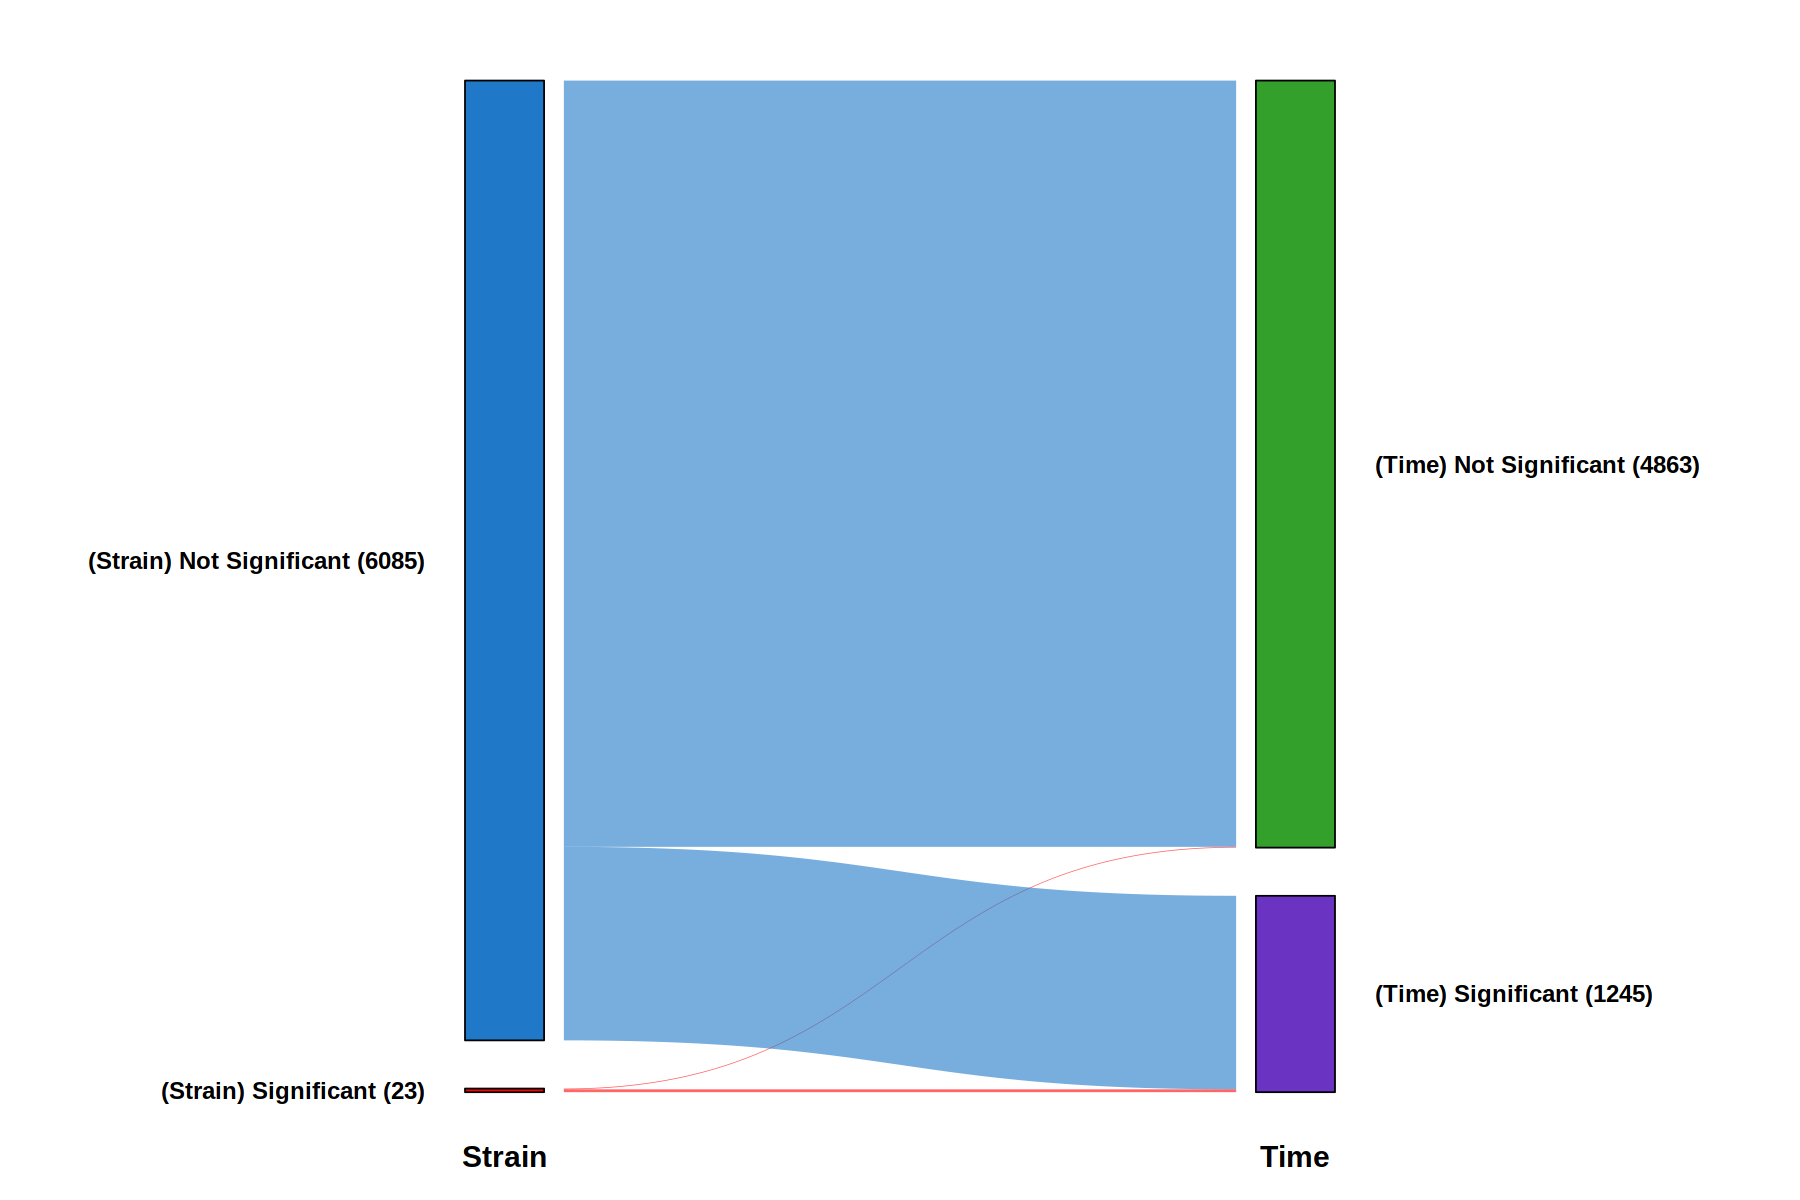

In [17]:
# Show relationships of the genes that have a significant strain and time effects,
# change colour and add number of genes in each classification
plot_parallel(sig_strain, sig_time, labels = c("Strain", "Time"), color = pals::cols25(), add_counts = TRUE)

### Use `TENxPBMCData` dataset

In [18]:
#--- data-loading ---#
sce.pbmc <- TENxPBMCData("pbmc4k")
sce.pbmc

snapshotDate(): 2021-05-18

see ?TENxPBMCData and browseVignettes('TENxPBMCData') for documentation

loading from cache



class: SingleCellExperiment 
dim: 33694 4340 
metadata(0):
assays(1): counts
rownames(33694): ENSG00000243485 ENSG00000237613 ... ENSG00000277475 ENSG00000268674
rowData names(3): ENSEMBL_ID Symbol_TENx Symbol
colnames: NULL
colData names(11): Sample Barcode ... Individual Date_published
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [19]:
#--- gene-annotation ---#
rownames(sce.pbmc) <- uniquifyFeatureNames(rowData(sce.pbmc)$ENSEMBL_ID, rowData(sce.pbmc)$Symbol)
is.mito <- grep("^MT-", rowData(sce.pbmc)$Symbol_TENx)

In [20]:
#--- quality-control ---#
stats <- perCellQCMetrics(sce.pbmc, subsets = list(Mito = is.mito))
high.mito <- isOutlier(stats$subsets_Mito_percent, type = "higher")
sce.pbmc <- sce.pbmc[,!high.mito]

In [21]:
#--- normalization ---#
set.seed(10001)
clusters <- quickCluster(sce.pbmc)
sce.pbmc <- computeSumFactors(sce.pbmc, cluster = clusters)
sce.pbmc <- logNormCounts(sce.pbmc)

In [22]:
#--- variance-modelling ---#
set.seed(10001)
dec.pbmc <- modelGeneVarByPoisson(sce.pbmc)
top.pbmc <- getTopHVGs(dec.pbmc, prop = 0.1)

In [23]:
#--- dimensionality-reduction ---#
set.seed(10001)
sce.pbmc <- denoisePCA(sce.pbmc, subset.row = top.pbmc, technical = dec.pbmc)

set.seed(10001)
sce.pbmc <- runTSNE(sce.pbmc, dimred = "PCA")

set.seed(10001)
sce.pbmc <- runUMAP(sce.pbmc, dimred = "PCA")

sce.pbmc

class: SingleCellExperiment 
dim: 33694 4175 
metadata(0):
assays(2): counts logcounts
rownames(33694): ENSG00000243485 FAM138A ... ENSG00000277475 FAM231C
rowData names(3): ENSEMBL_ID Symbol_TENx Symbol
colnames: NULL
colData names(12): Sample Barcode ... Date_published sizeFactor
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):

In [24]:
#--- walktrap clustering ---#
clu.walktrap <- clusterCells(sce.pbmc, use.dimred = "PCA", BLUSPARAM = NNGraphParam(cluster.fun = "walktrap"))
table(clu.walktrap)

clu.walktrap
   1    2    3    4    5    6    7    8    9   10   11 
 187  563  526  811  605  128 1011   46  197   84   17 

In [25]:
#--- louvain clustering ---#
clu.louvain <- clusterCells(sce.pbmc, use.dimred = "PCA", BLUSPARAM = NNGraphParam(cluster.fun = "louvain"))
table(clu.louvain)

clu.louvain
  1   2   3   4   5   6   7   8   9  10  11  12  13  14 
 46 152 366 583  85 605 358 536 371 429  37 188 292 127 

In [26]:
table(clu.walktrap, clu.louvain)

            clu.louvain
clu.walktrap   1   2   3   4   5   6   7   8   9  10  11  12  13  14
          1    0   0   0   0   0   0   0   0   0   0   0 187   0   0
          2    0   3   1   6   0   0 146   0 361   9  37   0   0   0
          3    0 149 365   0   0   0   1   0  10   0   0   1   0   0
          4    0   0   0   0   1   0   0 535   0   0   0   0 275   0
          5    0   0   0   0   0 605   0   0   0   0   0   0   0   0
          6    0   0   0   0   0   0   0   0   0   0   0   0   1 127
          7    0   0   0 577   0   0  14   0   0 420   0   0   0   0
          8   46   0   0   0   0   0   0   0   0   0   0   0   0   0
          9    0   0   0   0   0   0 197   0   0   0   0   0   0   0
          10   0   0   0   0  84   0   0   0   0   0   0   0   0   0
          11   0   0   0   0   0   0   0   1   0   0   0   0  16   0

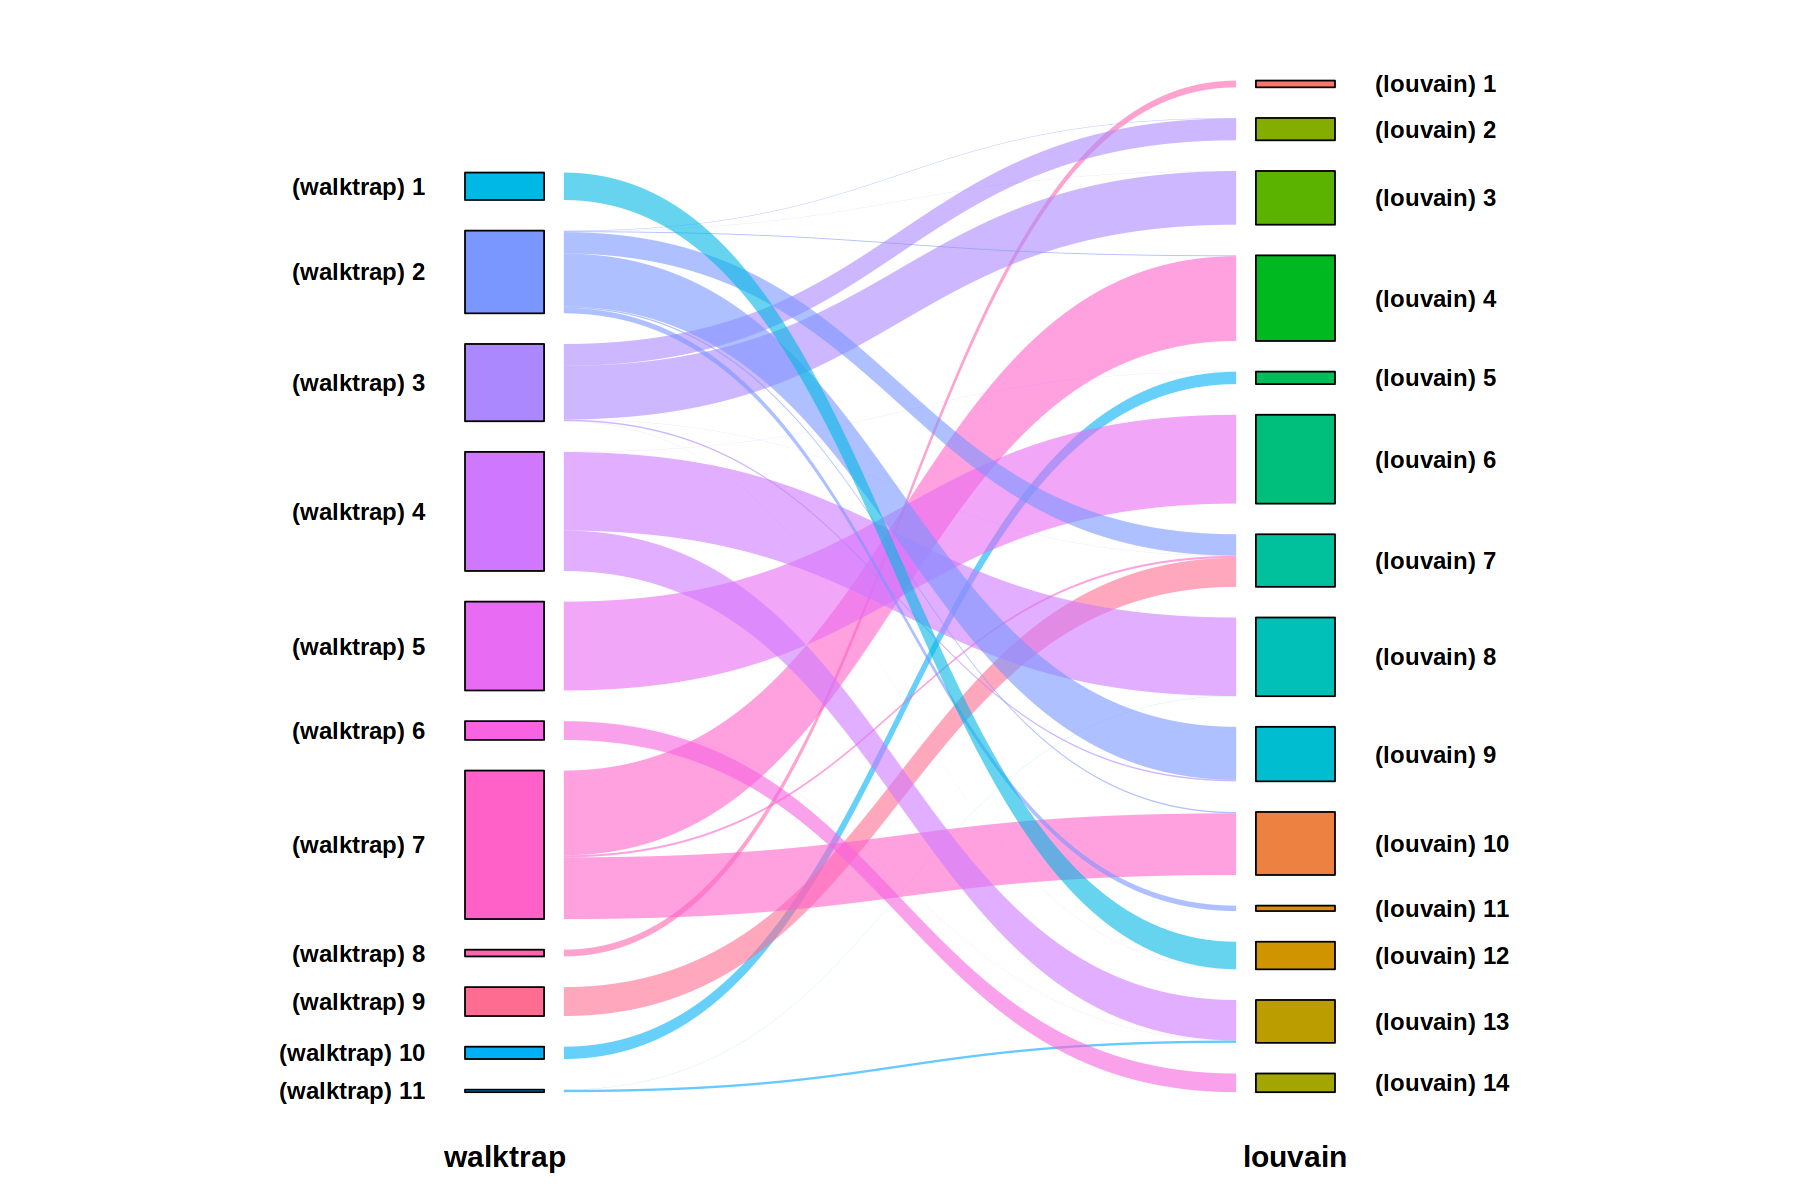

In [27]:
# Show relationships of 2 different cluster assignments of cells
plot_parallel(clu.walktrap, clu.louvain, labels = c("walktrap", "louvain"))

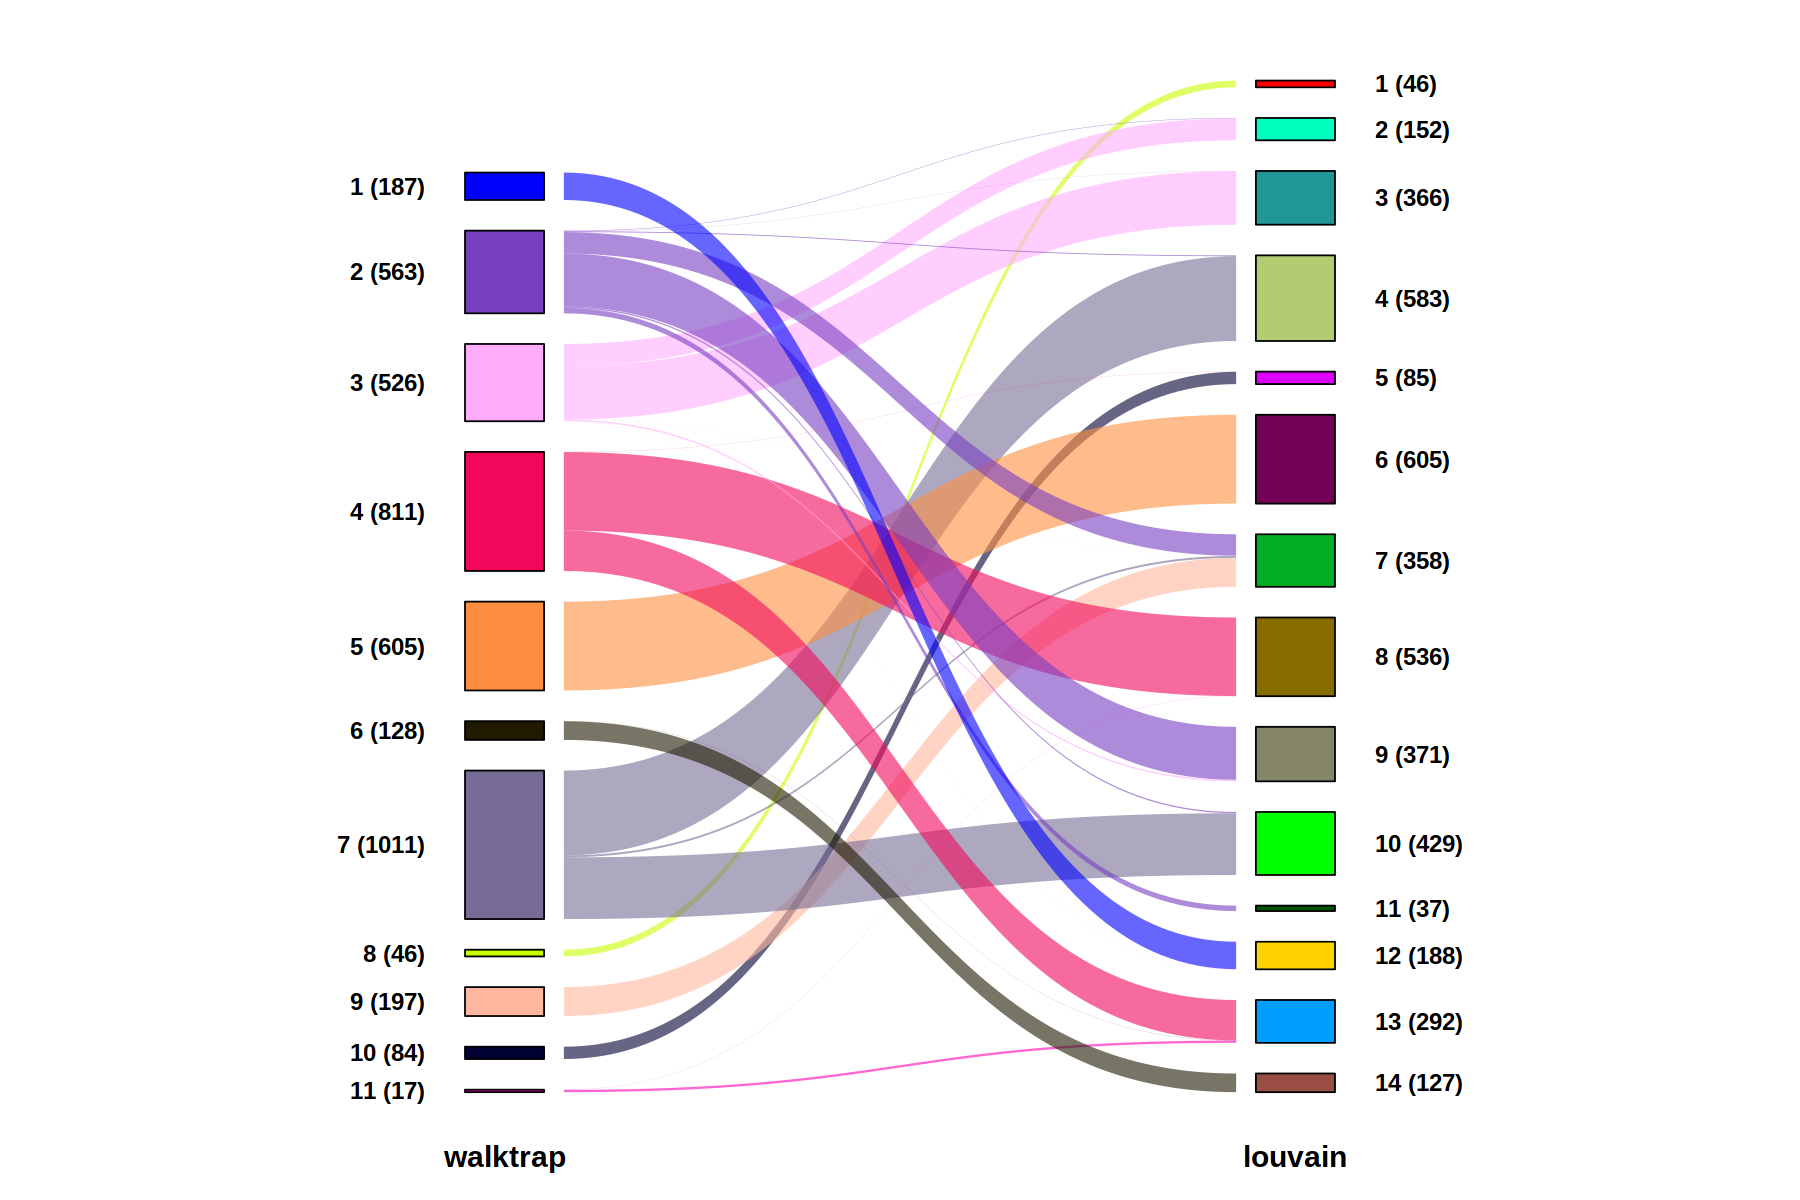

In [28]:
# Show relationships of 2 different cluster assignments of cells,
# change colour and add number of cells in each classification
plot_parallel(clu.walktrap, clu.louvain, labels = c("walktrap", "louvain"), color = glasbey(), add_counts = TRUE)

## Session info

In [29]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/ihsuan/miniconda3_4.10.0/envs/r4/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C               LC_TIME=en_GB.UTF-8       
 [4] LC_COLLATE=en_GB.UTF-8     LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] TENxPBMCData_1.10.0         HDF5Array_1.20.0            rhdf5_2.36.0               
 [4] DelayedArray_0.18.0         Matrix_1.3-4                bluster_1.2.1              
 [7] scran_1.20.1                scater_1.20.0               scuttle_1.2.0              
[10] SingleCellExperimen